# Quantum vs. Classical Implementation of Portfolio optimization using Markowitz Portfolio Theory

## Import Packages

In [33]:
# Optimization modeling
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# QAOA & optimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

# Aer Sampler primitive for QAOA
from qiskit_aer.primitives import Sampler

# Numerical & stock data libraries
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from pypfopt import expected_returns, risk_models, EfficientFrontier
import warnings
import time
from scipy.optimize import minimize
import itertools
import seaborn as sns


# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="qiskit_aer")

## Quantum Implementation - QAOA using Qiskit

In [34]:
class Quantum:
    def __init__(self, B, days, interval, start):
        # Tickers of Magnificent 7 stocks
        self.tickers = [
            'AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'TSLA', 
            'AVGO', 'BRK-B', 'JPM', 'LLY', 'UNH', 'XOM', 'V', 'MA', 'PG', 
            'JNJ', 'HD', 'COST', 'NFLX', 'CRM', 'CVX', 'BAC', 'ABBV'
        ]
        self.n = len(self.tickers)
        
        # Ensure Budget is within range
        if not (1 <= B <= self.n):
            raise ValueError(f"Budget must be between 1 and {self.n}")
        
        self.B = B
        
        # Download Data from Yahoo Finance
        self.data = self.download_data(days, interval, start)

        # Expected Returns and Covariance Matrix
        self.mu = np.empty((self.n, 1))
        self.sigma = np.empty((self.n, self.n))

        # Parameters for QUBO formulation
        self.risk_aversion = 1.0  # Risk aversion parameter
        self.penalty_strength = 10.0  # Penalty for constraint violation

        # QUBO Matrix for QAOA Optimization
        self.qubo_matrix = np.empty((self.n, self.n))

    def download_data(self, days, interval, start):
        """Download data with proper error handling and automatic end date calculation"""
    
        # Convert start date string to datetime object
        start_date = datetime.strptime(start, '%Y-%m-%d')
        
        # Calculate end date by adding the specified number of days
        # We add extra days to account for weekends and holidays
        # Typically need about 1.4x calendar days to get the desired trading days
        calendar_days_needed = int(days * 1.4) + 7  # Add weekends/holidays
        end_date = start_date + timedelta(days=calendar_days_needed)
        end_date = end_date.strftime('%Y-%m-%d')
        
        print(f"Downloading data from {start} to {end_date} (to get ~{days} trading days)")
        
        data = yf.download(
            tickers=self.tickers, 
            start=start,
            end=end_date, 
            interval=interval,
            auto_adjust=True,
            rounding=True,
            progress=False
        )['Close']
        
        # Handle single ticker case
        if len(self.tickers) == 1:
            data = pd.DataFrame(data, columns=self.tickers)
        
        # Limit to the requested number of days
        if len(data) > days:
            data = data.tail(days)  # Take the most recent 'days' trading days
        
        if data.empty:
            raise ValueError("No data available for the specified period")
        
        actual_days = len(data)
        print(f"Successfully downloaded {actual_days} trading days of data")
        
        return data
            
    def compute_returns(self):
        """Compute daily returns matrix"""
        returns = self.data.pct_change().dropna()
        
        if returns.empty:
            raise ValueError("Insufficient data to compute returns")
            
        returns_matrix = returns.to_numpy()
        return returns_matrix
    
    def compute_mu(self, returns_matrix):
        """Compute expected returns (mean of historical returns)"""
        self.mu = np.mean(returns_matrix, axis=0).reshape(-1, 1)
        return self.mu

    def covariance_matrix(self, returns_matrix):
        """Compute covariance matrix of returns"""
        self.sigma = np.cov(returns_matrix.T)
        return self.sigma

    def build_qubo_matrix(self, mu, sigma, risk_aversion, penalty_strength, B):
        """
        Build QUBO matrix for portfolio optimization
        Objective: Minimize risk - expected_return + penalty for constraint violation
        
        The QUBO formulation for selecting exactly B assets:
        Q_ii = risk_aversion * sigma_ii - mu_i + penalty * (1 - 2*B)
        Q_ij = risk_aversion * sigma_ij + 2 * penalty (for i != j)
        """
        
        # Initialize QUBO matrix
        self.qubo_matrix = np.zeros((self.n, self.n))
        
        # Diagonal terms: individual asset risk and return, plus penalty
        for i in range(self.n):
            self.qubo_matrix[i, i] = (risk_aversion * sigma[i, i] - mu[i, 0] + penalty_strength * (1 - 2 * B))
        
        # Off-diagonal terms: covariance and penalty
        for i in range(self.n):
            for j in range(i + 1, self.n):
                covariance_term = risk_aversion * sigma[i, j]
                penalty_term = 2 * penalty_strength
                
                self.qubo_matrix[i, j] = covariance_term + penalty_term
                self.qubo_matrix[j, i] = covariance_term + penalty_term
        
        return self.qubo_matrix

    def build_quadratic_program(self, qubo):
        """Build quadratic program for Qiskit optimization"""
        program = QuadraticProgram()

        # Add binary variables for each asset
        for i in range(self.n):
            program.binary_var(name=f"x{i}")

        # Build objective function from QUBO matrix
        linear = {}
        quadratic = {}

        # Linear terms (diagonal of QUBO)
        for i in range(self.n):
            linear[i] = qubo[i, i]

        # Quadratic terms (off-diagonal of QUBO)
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if qubo[i, j] != 0:
                    quadratic[(i, j)] = qubo[i, j]

        program.minimize(linear=linear, quadratic=quadratic)
        
        # Add constraint: select exactly B assets
        program.linear_constraint(
            linear={i: 1 for i in range(self.n)},
            sense="==",
            rhs=self.B,
            name="asset_selection"
        )

        return program

    def quantum_optimizer(self, program, max_iterations=200):
        """Run QAOA optimization"""
        try:
            # Set up QAOA with more iterations using SamplerV2
            sampler = Sampler()
            optimizer = COBYLA(maxiter=max_iterations)
            qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=2)  # 2 QAOA layers

            solver = MinimumEigenOptimizer(qaoa)
            result = solver.solve(program)
        
            return result
        except Exception as e:
            raise Exception(f"Optimization failed: {str(e)}")

    def analyze_solution(self, result):
        """Analyze and display the optimization results"""
        if result.x is None:
            print("No solution found")
            return None, None, None
        
        x_opt = result.x
        fval = result.fval
        
        # Get selected assets
        selected_assets = [self.tickers[i] for i in range(self.n) if x_opt[i] == 1]
        
        # Calculate portfolio metrics
        selected_indices = [i for i in range(self.n) if x_opt[i] == 1]
        
        if len(selected_indices) > 0:
            portfolio_return = np.sum([self.mu[i, 0] for i in selected_indices])
            
            # Portfolio risk (variance)
            portfolio_variance = 0
            for i in selected_indices:
                for j in selected_indices:
                    portfolio_variance += self.sigma[i, j]
            
            portfolio_risk = np.sqrt(portfolio_variance)
        else:
            portfolio_return = 0
            portfolio_risk = 0
        
        return selected_assets, portfolio_return, portfolio_risk, fval

    def optimization(self):
        """Run the complete optimization process"""
        print("Computing returns and statistics...")
        
        # Compute returns and statistics
        returns_matrix = self.compute_returns()
        mu = self.compute_mu(returns_matrix)
        sigma = self.covariance_matrix(returns_matrix)
        
        print(f"Expected returns: {mu.flatten()}")
        print(f"Risk (std dev): {np.sqrt(np.diag(sigma))}")
        
        # Build QUBO matrix
        qubo_matrix = self.build_qubo_matrix(mu, sigma, self.risk_aversion, self.penalty_strength, self.B)
        
        # Create optimization program
        program = self.build_quadratic_program(qubo_matrix)
        
        print("Running QAOA optimization...")
        
        # Run optimization
        result = self.quantum_optimizer(program)
        
        # Analyze results
        selected_assets, portfolio_return, portfolio_risk, objective_value = self.analyze_solution(result)
        
        return {
            'selected_assets': selected_assets,
            'portfolio_return': portfolio_return,
            'portfolio_risk': portfolio_risk,
            'objective_value': objective_value,
            'mu': mu,
            'sigma': sigma
        }

## Classical Implementation - Brute Force

In [35]:
class Classical:
    def __init__(self, B, days, interval, start):
        # Tickers of Magnificent 7 stocks
        self.tickers = [
            'AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'TSLA', 
            'AVGO', 'BRK-B', 'JPM', 'LLY', 'UNH', 'XOM', 'V', 'MA', 'PG', 
            'JNJ', 'HD', 'COST', 'NFLX', 'CRM', 'CVX', 'BAC', 'ABBV'
        ]
        
        self.n = len(self.tickers)
        
        # Ensure Budget is within range
        if not (1 <= B <= self.n):
            raise ValueError(f"Budget must be between 1 and {self.n}")
        
        self.B = B

        # Download Data from Yahoo Finance
        self.data = self.download_data(days, interval, start)

        # Expected Returns and Covariance Matrix
        self.mu = np.empty((self.n, 1))
        self.sigma = np.empty((self.n, self.n))

        # Parameters for optimization
        self.risk_aversion = 1.0  # Risk aversion parameter

    def download_data(self, days, interval, start):
        """Download data with proper error handling and automatic end date calculation"""

        # Convert start date string to datetime object
        start_date = datetime.strptime(start, '%Y-%m-%d')
        
        # Calculate end date by adding the specified number of days
        calendar_days_needed = int(days * 1.4) + 7  # Add weekends/holidays
        end_date = start_date + timedelta(days=calendar_days_needed)
        end_date = end_date.strftime('%Y-%m-%d')
        
        print(f"Downloading data from {start} to {end_date} (to get ~{days} trading days)")
        
        data = yf.download(
            tickers=self.tickers, 
            start=start,
            end=end_date, 
            interval=interval,
            auto_adjust=True,
            rounding=True,
            progress=False
        )['Close']
        
        # Handle single ticker case
        if len(self.tickers) == 1:
            data = pd.DataFrame(data, columns=self.tickers)
        
        # Limit to the requested number of days
        if len(data) > days:
            data = data.tail(days)  # Take the most recent 'days' trading days
        
        if data.empty:
            raise ValueError("No data available for the specified period")
        
        actual_days = len(data)
        print(f"Successfully downloaded {actual_days} trading days of data")
        
        return data
    
    def compute_returns(self):
        """Compute daily returns matrix"""
        returns = self.data.pct_change().dropna()
        
        if returns.empty:
            raise ValueError("Insufficient data to compute returns")
            
        returns_matrix = returns.to_numpy()
        return returns_matrix
    
    def compute_mu(self, returns_matrix):
        """Compute expected returns (mean of historical returns)"""
        self.mu = np.mean(returns_matrix, axis=0).reshape(-1, 1)
        return self.mu

    def covariance_matrix(self, returns_matrix):
        """Compute covariance matrix of returns"""
        self.sigma = np.cov(returns_matrix.T)
        return self.sigma
    
    def optimization(self):
        print("Optimizing Classically using Brute Force: ")

        returns_matrix = self.compute_returns()
        mu = self.compute_mu(returns_matrix)
        sigma = self.covariance_matrix(returns_matrix)

        best_combination = None
        best_objective = float('inf')
        best_return = 0
        best_risk = 0

        for k in itertools.combinations(range(self.n), self.B):
            # Calculate Portfolio return
            portfolio_return = np.sum([mu[i, 0] for i in k])

            # Calculate portfolio risk (variance)
            portfolio_variance = 0
            for i in k:
                for j in k:
                    portfolio_variance += sigma[i, j]
            
            portfolio_risk = np.sqrt(portfolio_variance)

            # Objective function: minimize risk - return (same as QAOA)
            objective = self.risk_aversion * portfolio_variance - portfolio_return
            
            if objective < best_objective:
                best_objective = objective
                best_combination = k
                best_return = portfolio_return
                best_risk = portfolio_risk

            selected_assets = [self.tickers[i] for i in best_combination]

        return {
            'selected_assets': selected_assets,
            'portfolio_return': best_return,
            'portfolio_risk': best_risk,
            'objective_value': best_objective,
            'mu': mu,
            'sigma': sigma
        }

## Compare QAOA vs Brute Force

🚀 QUANTUM VS CLASSICAL PORTFOLIO OPTIMIZATION

🔬 PORTFOLIO OPTIMIZATION COMPARISON
📊 Problem Setup:
   • Select 15 assets from 7 Magnificent 7 stocks
   • Using 50 trading days from 2024-01-01
   • Data interval: 1d

🚀 Initializing optimizers...
Successfully downloaded 50 trading days of data
Successfully downloaded 50 trading days of data

🔬 Running Quantum QAOA Optimization...
Computing returns and statistics...
Expected returns: [-0.00097915  0.00221173  0.00399132  0.00365211  0.0011722   0.00238475
  0.00243742  0.00340526  0.00094994  0.00076286  0.00086586  0.00216518
 -0.00013335  0.00216901  0.00436924  0.00264307  0.00735143  0.00264893
  0.00520688  0.01296056  0.00184211 -0.00717618 -0.00197982  0.00184023
  0.00196995]
Risk (std dev): [0.01150599 0.00887999 0.01786733 0.02515991 0.01275442 0.0076509
 0.01454651 0.01710316 0.01249246 0.01790392 0.01795189 0.01041653
 0.00725882 0.00816837 0.01726744 0.01002771 0.03396953 0.01291976
 0.02126163 0.03434223 0.00855206 0.029599

C:\Users\adity\AppData\Local\Temp\ipykernel_19852\2146435847.py:221: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result = self.quantum_optimizer(program)


✅ Quantum optimization completed in 484.9405 seconds

💻 Running Classical Brute Force Optimization...
Optimizing Classically using Brute Force: 
✅ Classical optimization completed in 177.3369 seconds

📊 DETAILED COMPARISON ANALYSIS
💰 Portfolio Return Analysis:
   Quantum:   0.050082
   Classical: 0.056948
   Difference: -12.06%
   Winner: Classical

⚠️  Portfolio Risk Analysis:
   Quantum:   0.149807
   Classical: 0.129513
   Difference: +15.67%
   Lower Risk: Classical

🎯 Objective Function Analysis (Lower = Better):
   Quantum:   -2250.036239
   Classical: -0.040174
   Difference: -5600565.01%
   Winner: Quantum

⏱️  Execution Time Analysis:
   Quantum:   484.9405 seconds
   Classical: 177.3369 seconds
   Speed Ratio (Q/C): 2.73x
   Faster: Classical

📈 Portfolio Composition Analysis:
   Quantum Selected:   ['AMZN', 'BRK-B', 'COST', 'GOOGL', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'NFLX', 'NVDA', 'PG', 'TSLA', 'UNH', 'V']
   Classical Selected: ['ABBV', 'BAC', 'COST', 'GOOG', 'GOOGL', 'HD

C:\Users\adity\AppData\Local\Temp\ipykernel_19852\2342998137.py:409: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
c:\home\adityasunke04\Q-Folio\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


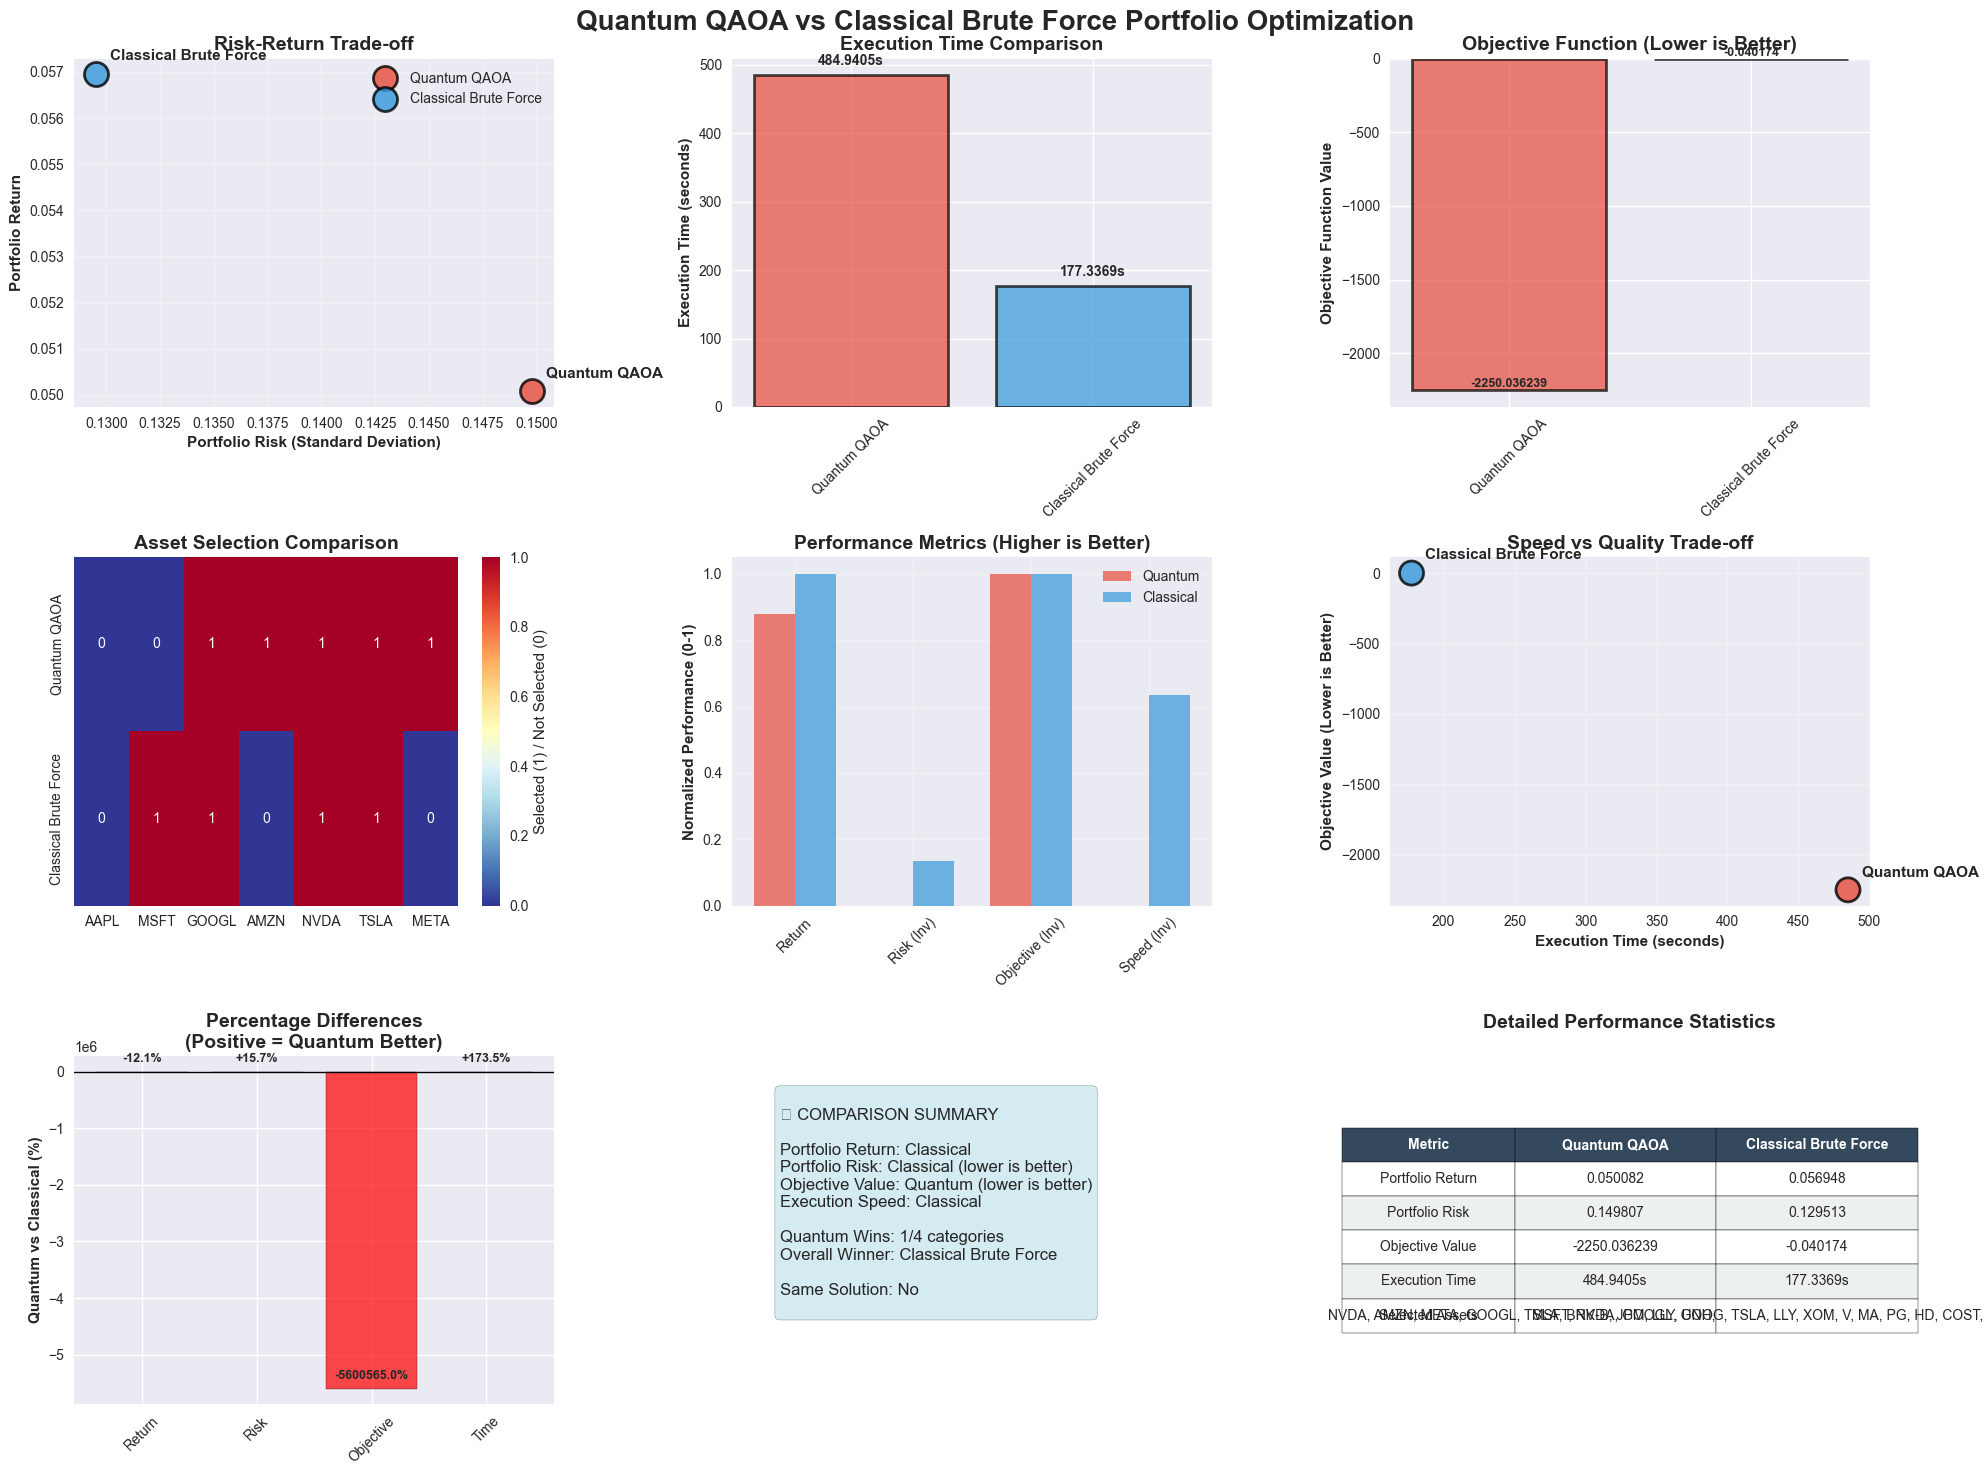


✅ Comparison completed successfully!
📊 Check the generated visualization for detailed insights.


In [36]:
import matplotlib.pyplot as plt
from typing import Dict, Any, Tuple

# Import quantum libraries - uncomment these when you have qiskit installed
# from qiskit.algorithms.optimizers import COBYLA
# from qiskit.algorithms import QAOA
# from qiskit.primitives import Sampler
# from qiskit_optimization import QuadraticProgram
# from qiskit_optimization.algorithms import MinimumEigenOptimizer

def run_portfolio_comparison(B: int = 15, days: int = 50, interval: str = '1d', start: str = '2024-01-01'):
    """
    Complete comparison between Quantum QAOA and Classical Brute Force portfolio optimization
    
    Args:
        B: Number of assets to select (budget constraint)
        days: Number of historical trading days to use
        interval: Data interval ('1d', '1wk', etc.)
        start: Start date string ('YYYY-MM-DD')
    
    Returns:
        Dictionary containing all comparison results and metrics
    """
    
    print("🔬 PORTFOLIO OPTIMIZATION COMPARISON")
    print("=" * 60)
    print(f"📊 Problem Setup:")
    print(f"   • Select {B} assets from 7 Magnificent 7 stocks")
    print(f"   • Using {days} trading days from {start}")
    print(f"   • Data interval: {interval}")
    print("=" * 60)
    
    # Initialize optimizers
    print("\n🚀 Initializing optimizers...")
    
    # You'll need to uncomment these lines and import your classes
    quantum_opt = Quantum(B, days, interval, start)
    classical_opt = Classical(B, days, interval, start)
    
    
    # Run Quantum Optimization
    print("\n🔬 Running Quantum QAOA Optimization...")
    start_time = time.time()
    try:
        quantum_results = quantum_opt.optimization()
        quantum_results['execution_time'] = time.time() - start_time
        quantum_results['method'] = 'Quantum QAOA'
        print(f"✅ Quantum optimization completed in {quantum_results['execution_time']:.4f} seconds")
    except Exception as e:
        print(f"❌ Quantum optimization failed: {str(e)}")
        quantum_results = None
    
    # Run Classical Optimization
    print("\n💻 Running Classical Brute Force Optimization...")
    start_time = time.time()
    try:
        classical_results = classical_opt.optimization()
        classical_results['execution_time'] = time.time() - start_time
        classical_results['method'] = 'Classical Brute Force'
        print(f"✅ Classical optimization completed in {classical_results['execution_time']:.4f} seconds")
    except Exception as e:
        print(f"❌ Classical optimization failed: {str(e)}")
        classical_results = None
    
    # Perform comparison analysis
    if quantum_results and classical_results:
        comparison_metrics = analyze_comparison(quantum_results, classical_results)
        visualization = create_comprehensive_visualization(quantum_results, classical_results, comparison_metrics)
        
        return {
            'quantum_results': quantum_results,
            'classical_results': classical_results,
            'comparison_metrics': comparison_metrics,
            'visualization': visualization
        }
    else:
        print("❌ Cannot perform comparison - one or both optimizations failed")
        return None

def analyze_comparison(quantum_results: Dict[str, Any], classical_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Comprehensive analysis comparing quantum and classical results
    """
    
    print("\n📊 DETAILED COMPARISON ANALYSIS")
    print("=" * 60)
    
    # Extract key metrics
    q_return = quantum_results['portfolio_return']
    c_return = classical_results['portfolio_return']
    q_risk = quantum_results['portfolio_risk']
    c_risk = classical_results['portfolio_risk']
    q_objective = quantum_results['objective_value']
    c_objective = classical_results['objective_value']
    q_time = quantum_results['execution_time']
    c_time = classical_results['execution_time']
    q_assets = set(quantum_results['selected_assets'])
    c_assets = set(classical_results['selected_assets'])
    
    # Calculate percentage differences
    return_diff_pct = ((q_return - c_return) / abs(c_return)) * 100 if c_return != 0 else 0
    risk_diff_pct = ((q_risk - c_risk) / c_risk) * 100 if c_risk != 0 else 0
    obj_diff_pct = ((q_objective - c_objective) / abs(c_objective)) * 100 if c_objective != 0 else 0
    time_ratio = q_time / c_time if c_time != 0 else float('inf')
    
    # Determine winners
    better_return = "Quantum" if q_return > c_return else "Classical"
    better_risk = "Quantum" if q_risk < c_risk else "Classical"  # Lower risk is better
    better_objective = "Quantum" if q_objective < c_objective else "Classical"  # Lower objective is better
    faster_method = "Quantum" if q_time < c_time else "Classical"
    
    # Solution similarity
    same_solution = q_assets == c_assets
    common_assets = q_assets.intersection(c_assets)
    unique_quantum = q_assets - c_assets
    unique_classical = c_assets - q_assets
    
    # Print detailed analysis
    print(f"💰 Portfolio Return Analysis:")
    print(f"   Quantum:   {q_return:.6f}")
    print(f"   Classical: {c_return:.6f}")
    print(f"   Difference: {return_diff_pct:+.2f}%")
    print(f"   Winner: {better_return}")
    print()
    
    print(f"⚠️  Portfolio Risk Analysis:")
    print(f"   Quantum:   {q_risk:.6f}")
    print(f"   Classical: {c_risk:.6f}")
    print(f"   Difference: {risk_diff_pct:+.2f}%")
    print(f"   Lower Risk: {better_risk}")
    print()
    
    print(f"🎯 Objective Function Analysis (Lower = Better):")
    print(f"   Quantum:   {q_objective:.6f}")
    print(f"   Classical: {c_objective:.6f}")
    print(f"   Difference: {obj_diff_pct:+.2f}%")
    print(f"   Winner: {better_objective}")
    print()
    
    print(f"⏱️  Execution Time Analysis:")
    print(f"   Quantum:   {q_time:.4f} seconds")
    print(f"   Classical: {c_time:.4f} seconds")
    print(f"   Speed Ratio (Q/C): {time_ratio:.2f}x")
    print(f"   Faster: {faster_method}")
    print()
    
    print(f"📈 Portfolio Composition Analysis:")
    print(f"   Quantum Selected:   {sorted(list(q_assets))}")
    print(f"   Classical Selected: {sorted(list(c_assets))}")
    print(f"   Identical Solutions: {'Yes' if same_solution else 'No'}")
    print(f"   Common Assets: {sorted(list(common_assets))}")
    if unique_quantum:
        print(f"   Only in Quantum: {sorted(list(unique_quantum))}")
    if unique_classical:
        print(f"   Only in Classical: {sorted(list(unique_classical))}")
    print()
    
    # Overall assessment
    print(f"🏆 OVERALL ASSESSMENT:")
    quantum_wins = sum([
        q_return > c_return,     # Better return
        q_risk < c_risk,         # Lower risk
        q_objective < c_objective, # Better objective
        q_time < c_time          # Faster execution
    ])
    
    print(f"   Quantum wins in {quantum_wins}/4 categories")
    print(f"   Classical wins in {4-quantum_wins}/4 categories")
    
    if quantum_wins > 2:
        overall_winner = "Quantum QAOA"
    elif quantum_wins < 2:
        overall_winner = "Classical Brute Force"
    else:
        overall_winner = "Tie"
    
    print(f"   Overall Winner: {overall_winner}")
    print()
    
    # Store all metrics
    comparison_metrics = {
        'return_difference_pct': return_diff_pct,
        'risk_difference_pct': risk_diff_pct,
        'objective_difference_pct': obj_diff_pct,
        'time_ratio': time_ratio,
        'better_return': better_return,
        'better_risk': better_risk,
        'better_objective': better_objective,
        'faster_method': faster_method,
        'same_solution': same_solution,
        'common_assets': list(common_assets),
        'unique_quantum': list(unique_quantum),
        'unique_classical': list(unique_classical),
        'quantum_wins': quantum_wins,
        'overall_winner': overall_winner
    }
    
    return comparison_metrics

def create_comprehensive_visualization(quantum_results: Dict[str, Any], 
                                     classical_results: Dict[str, Any], 
                                     comparison_metrics: Dict[str, Any]):
    """
    Create comprehensive visualization comparing both methods
    """
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Quantum QAOA vs Classical Brute Force Portfolio Optimization', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # Data preparation
    methods = ['Quantum QAOA', 'Classical Brute Force']
    colors = ['#e74c3c', '#3498db']  # Red for Quantum, Blue for Classical
    
    q = quantum_results
    c = classical_results
    
    returns = [q['portfolio_return'], c['portfolio_return']]
    risks = [q['portfolio_risk'], c['portfolio_risk']]
    objectives = [q['objective_value'], c['objective_value']]
    times = [q['execution_time'], c['execution_time']]
    
    # 1. Risk-Return Scatter Plot
    ax1 = plt.subplot(3, 3, 1)
    for i, method in enumerate(methods):
        ax1.scatter(risks[i], returns[i], s=300, alpha=0.8, 
                   color=colors[i], label=method, edgecolors='black', linewidth=2)
        ax1.annotate(method, (risks[i], returns[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Portfolio Risk (Standard Deviation)', fontweight='bold')
    ax1.set_ylabel('Portfolio Return', fontweight='bold')
    ax1.set_title('Risk-Return Trade-off', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Execution Time Comparison
    ax2 = plt.subplot(3, 3, 2)
    bars = ax2.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Execution Time (seconds)', fontweight='bold')
    ax2.set_title('Execution Time Comparison', fontweight='bold', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, time_val in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.02,
                f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')
    
    # 3. Objective Function Values
    ax3 = plt.subplot(3, 3, 3)
    bars = ax3.bar(methods, objectives, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Objective Function Value', fontweight='bold')
    ax3.set_title('Objective Function (Lower is Better)', fontweight='bold', fontsize=14)
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, obj_val in zip(bars, objectives):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(objectives)*0.02,
                f'{obj_val:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 4. Portfolio Composition Heatmap
    ax4 = plt.subplot(3, 3, 4)
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META']
    
    selection_matrix = []
    for result in [q, c]:
        row = [1 if ticker in result['selected_assets'] else 0 for ticker in tickers]
        selection_matrix.append(row)
    
    sns.heatmap(selection_matrix, 
                xticklabels=tickers,
                yticklabels=methods,
                cmap='RdYlBu_r',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Selected (1) / Not Selected (0)'},
                ax=ax4)
    ax4.set_title('Asset Selection Comparison', fontweight='bold', fontsize=14)
    
    # 5. Performance Metrics Radar Chart
    ax5 = plt.subplot(3, 3, 5)
    
    # Normalize metrics (higher is better for all)
    max_return = max(returns)
    max_risk = max(risks)
    max_obj = max(objectives)
    max_time = max(times)
    
    norm_returns = [r/max_return if max_return > 0 else 0 for r in returns]
    norm_risks = [1 - r/max_risk if max_risk > 0 else 1 for r in risks]  # Invert (lower is better)
    norm_objectives = [1 - o/max_obj if max_obj > 0 else 1 for o in objectives]  # Invert
    norm_times = [1 - t/max_time if max_time > 0 else 1 for t in times]  # Invert
    
    metrics_labels = ['Return', 'Risk (Inv)', 'Objective (Inv)', 'Speed (Inv)']
    
    x = np.arange(len(metrics_labels))
    width = 0.35
    
    quantum_scores = [norm_returns[0], norm_risks[0], norm_objectives[0], norm_times[0]]
    classical_scores = [norm_returns[1], norm_risks[1], norm_objectives[1], norm_times[1]]
    
    ax5.bar(x - width/2, quantum_scores, width, label='Quantum', color=colors[0], alpha=0.7)
    ax5.bar(x + width/2, classical_scores, width, label='Classical', color=colors[1], alpha=0.7)
    
    ax5.set_ylabel('Normalized Performance (0-1)', fontweight='bold')
    ax5.set_title('Performance Metrics (Higher is Better)', fontweight='bold', fontsize=14)
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics_labels, rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Time vs Quality Trade-off
    ax6 = plt.subplot(3, 3, 6)
    
    # Plot execution time vs objective value
    ax6.scatter(times, objectives, s=300, c=colors, alpha=0.8, edgecolors='black', linewidth=2)
    for i, method in enumerate(methods):
        ax6.annotate(method, (times[i], objectives[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')
    
    ax6.set_xlabel('Execution Time (seconds)', fontweight='bold')
    ax6.set_ylabel('Objective Value (Lower is Better)', fontweight='bold')
    ax6.set_title('Speed vs Quality Trade-off', fontweight='bold', fontsize=14)
    ax6.grid(True, alpha=0.3)
    
    # 7. Percentage Differences
    ax7 = plt.subplot(3, 3, 7)
    
    metrics_names = ['Return', 'Risk', 'Objective', 'Time']
    differences = [
        comparison_metrics['return_difference_pct'],
        comparison_metrics['risk_difference_pct'],
        comparison_metrics['objective_difference_pct'],
        (comparison_metrics['time_ratio'] - 1) * 100  # Convert ratio to percentage
    ]
    
    bar_colors = ['green' if d > 0 else 'red' for d in differences]
    bars = ax7.bar(metrics_names, differences, color=bar_colors, alpha=0.7, edgecolor='black')
    ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax7.set_ylabel('Quantum vs Classical (%)', fontweight='bold')
    ax7.set_title('Percentage Differences\n(Positive = Quantum Better)', fontweight='bold', fontsize=14)
    ax7.tick_params(axis='x', rotation=45)
    
    for bar, diff in zip(bars, differences):
        ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(differences) - min(differences))*0.02,
                f'{diff:+.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 8. Winner Summary
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('off')
    
    # Create winner summary
    winner_text = f"""
🏆 COMPARISON SUMMARY

Portfolio Return: {comparison_metrics['better_return']}
Portfolio Risk: {comparison_metrics['better_risk']} (lower is better)
Objective Value: {comparison_metrics['better_objective']} (lower is better)
Execution Speed: {comparison_metrics['faster_method']}

Quantum Wins: {comparison_metrics['quantum_wins']}/4 categories
Overall Winner: {comparison_metrics['overall_winner']}

Same Solution: {'Yes' if comparison_metrics['same_solution'] else 'No'}
"""
    
    ax8.text(0.1, 0.9, winner_text, transform=ax8.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    
    # 9. Detailed Statistics Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('tight')
    ax9.axis('off')
    
    table_data = [
        ['Portfolio Return', f'{q["portfolio_return"]:.6f}', f'{c["portfolio_return"]:.6f}'],
        ['Portfolio Risk', f'{q["portfolio_risk"]:.6f}', f'{c["portfolio_risk"]:.6f}'],
        ['Objective Value', f'{q["objective_value"]:.6f}', f'{c["objective_value"]:.6f}'],
        ['Execution Time', f'{q["execution_time"]:.4f}s', f'{c["execution_time"]:.4f}s'],
        ['Selected Assets', ', '.join(q['selected_assets']), ', '.join(c['selected_assets'])]
    ]
    
    table = ax9.table(cellText=table_data,
                     colLabels=['Metric', 'Quantum QAOA', 'Classical Brute Force'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.35, 0.35])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')
    
    ax9.set_title('Detailed Performance Statistics', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Main execution function
if __name__ == "__main__":
    print("🚀 QUANTUM VS CLASSICAL PORTFOLIO OPTIMIZATION")
    print("=" * 60)
    print()
    
    # Run demonstration
    demo_results = run_portfolio_comparison(B=15, days=50, interval='1d', start='2024-01-01')
    
    if demo_results:
        print("\n✅ Comparison completed successfully!")
        print("📊 Check the generated visualization for detailed insights.")
    else:
        print("\n❌ Comparison failed.")